In [1]:
# sklearn version 0.19.0 or 0.19.1 required
# import sklearn
# sklearn.__version__
# python 3.0 recommended

from __future__ import division, print_function, unicode_literals
import numpy as np
import pandas as pd
import os
import timeit
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split #from model_selection instead of cross_validation
from sklearn.model_selection import validation_curve #from model_selection instead of learning_curve
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

certain portion of code was borrowed from "Hands-On Machine Learning with Scikit-Learn and TensorFlow" Book

In [2]:
# To plot pretty figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "classification"
DATASET_ID = "_red-wine_" # for red wine dataset

# Functions
def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, PROJECT_ID + DATASET_ID + fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)
    
def plot_curve(sizes, data, dots=True, **kwargs):
    mu, std = data.mean(1), data.std(1)
    if dots:
        lines = plt.plot(sizes, mu, 'o-', **kwargs)
    else:
        lines = plt.plot(sizes, mu, '-', **kwargs)
    plt.fill_between(sizes, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.3)
    
def normalize_data(df, columns):
    for column in columns:
        mean_value = df.loc[:,column].mean()
        stdev = np.std(df.loc[:,column].values)
        df.loc[:,column] = (df.loc[:,column] - mean_value) / stdev
    return df

# Red Wine Quality Dateset (only red wine data)
https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Saving figure original_histogram


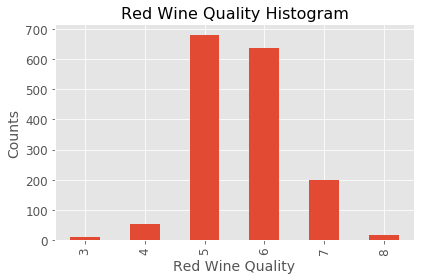

In [3]:
# load csv file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';') 

column_list = list(df.columns)[0:-1]
print (column_list)

# plot red wine quality counts histogram
df.quality.value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Red Wine Quality'); plt.ylabel('Counts')
plt.title('Red Wine Quality Histogram', fontsize=16)
save_fig('original_histogram', tight_layout=True)

Saving figure lumped_histogram


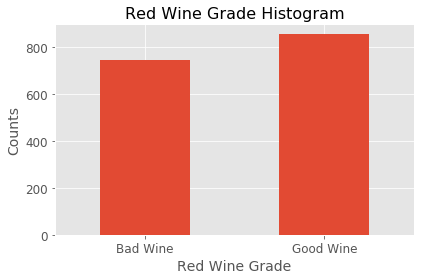

In [4]:
# Since some of the categories don't have enough samples, all categories are lumped into two major categories
# Grade 1: quality equal or better than 6
# Grade 2: all others
df['grade'] = np.array(['Good Wine' if i>=6 else 'Bad Wine' for i in df['quality']])
target = 'grade'

# plot lumped cagegories
df.grade.value_counts().sort_index(ascending=True).plot(kind = 'bar')
plt.xticks(rotation=0)
plt.xlabel('Red Wine Grade'); plt.ylabel('Counts')
plt.title('Red Wine Grade Histogram', fontsize=16)
save_fig('lumped_histogram', tight_layout=True)

since this binary dataset is well balanced, a simple accuracy calculation could do a good model evaluation job

https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/

In [5]:
X = df[column_list].values
y = df[target].values

# Data normalization is important for ANN
df = normalize_data(df, column_list) 
df.describe().T
X = df[column_list].values

# Data shuffling
X, y = shuffle(X, y, random_state=123)

# Data spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
X_train_size = X_train.shape[0]

In [6]:
df.grade.value_counts(normalize=True)

Good Wine    0.534709
Bad Wine     0.465291
Name: grade, dtype: float64

# DecisionTreeClassifier

Saving figure Decision Tree Complexity Curve (max_depth)


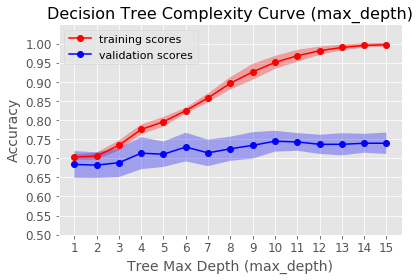

In [7]:
def plot_complexity_curve_dt():
    param_name="max_depth"
    param_range=range(1,16)
    val_train, val_test = validation_curve(DecisionTreeClassifier(random_state=0),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(param_range)
    plt.xlabel('Tree Max Depth (max_depth)'); plt.ylabel('Accuracy')
    plt.title('Decision Tree Complexity Curve (max_depth)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('Decision Tree Complexity Curve (max_depth)', tight_layout=True)
    
plot_complexity_curve_dt()

based on Decision Tree COmplexity Curve, max_depth = 10 is chosen for following Decision Tree analysis

Saving figure Decision Tree Learning Curve 1 (max_depth = 10)


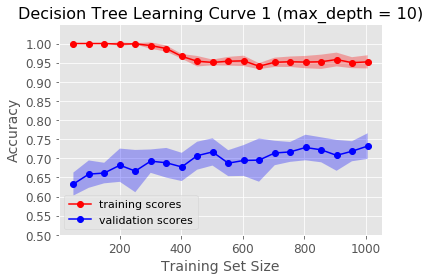

In [8]:
def plot_learning_curve_dt1():
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(DecisionTreeClassifier(max_depth=10),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('Decision Tree Learning Curve 1 (max_depth = 10)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('Decision Tree Learning Curve 1 (max_depth = 10)', tight_layout=True)
    
plot_learning_curve_dt1()

Saving figure Decision Tree Learning Curve 2 (max_depth = 6)


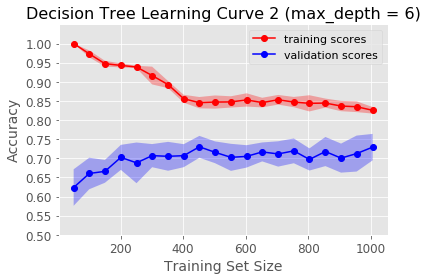

In [9]:
def plot_learning_curve_dt2():
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(DecisionTreeClassifier(max_depth=6),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('Decision Tree Learning Curve 2 (max_depth = 6)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('Decision Tree Learning Curve 2 (max_depth = 6)', tight_layout=True)
    
plot_learning_curve_dt2()

In [12]:
dt_clf = DecisionTreeClassifier(max_depth = 10, random_state=0)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [13]:
test_score = dt_clf.score(X_test, y_test)
print ('Decision Tree Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

Decision Tree Model Prediction Accuracy on Test Data: 0.7312


In [14]:
dt_clf = DecisionTreeClassifier(max_depth = 6, random_state=0)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [15]:
test_score = dt_clf.score(X_test, y_test)
print ('Decision Tree Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

Decision Tree Model Prediction Accuracy on Test Data: 0.7208


# MLPClassifier

# data normalizing is important for MLPClassifier

In [ ]:
# parameters={
# 'learning_rate': ["constant", "invscaling", "adaptive"],
# 'hidden_layer_sizes': [(100,1), (100,2), (100,3)],
# 'alpha': [10.0 ** -np.arange(1, 7)],
# 'activation': ["logistic", "relu", "Tanh"]
# }

# clf = gridSearchCV(estimator=MLPClassifier,param_grid=parameters,n_jobs=-1,verbose=2,cv=10)

In [ ]:
# first complexity curve on hidden layer size with default parameters
def plot_complexity_curve_mlp1():
    param_name="hidden_layer_sizes"
    param_range=range(1,41)
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r', dots = False)
    plot_curve(param_range, val_test, label='validation scores', color = 'b', dots = False)
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Hidden Layer (One Layer) Sizes (hidden_layer_sizes)'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 1 (hidden_layer_sizes)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('MLP Complexity Curve 1 (hidden_layer_sizes)', tight_layout=True)
    
plot_complexity_curve_mlp1()

In [ ]:
def plot_complexity_curve_mlp2():
    val_train_result = [np.array([])]
    val_train_std = np.array([])
    val_test_result = np.array([])
    val_test_std = np.array([])
    sizes = [(10,), (10, 10), (10, 10, 10), (10, 10, 10, 10), (10, 10, 10, 10, 10)]
    for i in sizes:
        clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes = i, random_state=0)
        results = cross_validate(clf, X_train, y_train, cv=10, return_train_score=True)

        val_train_result = np.append(val_train_result, results['train_score'].mean())
        val_test_result = np.append(val_test_result, results['test_score'].mean())
        val_train_std = np.append(val_train_std, results['train_score'].std())
        val_test_std = np.append(val_test_std, results['test_score'].std())                     
        
    lines1 = plt.plot(range(1,6),val_train_result , 'o-', color = 'r', label='training scores')
    lines2 = plt.plot(range(1,6),val_test_result , 'o-', color = 'b', label='test scores')

    plt.fill_between(range(1,6), val_train_result - val_train_std, val_train_result + val_train_std, edgecolor='none',
                     facecolor=lines1[0].get_color(), alpha=0.3)
    plt.fill_between(range(1,6), val_test_result - val_test_std, val_test_result + val_test_std, edgecolor='none',
                     facecolor=lines2[0].get_color(), alpha=0.3)
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(range(1, 6))
    plt.xlabel('Number of Hidden Layers'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 2 (hidden_layer numbers)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('MLP Complexity Curve 2 (hidden_layer numbers)', tight_layout=True)
    
plot_complexity_curve_mlp2()

In [ ]:
def plot_complexity_curve_mlp3():
    param_name="max_iter"
    param_range=[1, 3, 10, 32, 100, 320, 1000, 3200]
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', hidden_layer_sizes=10, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(range(0, 5))
    plt.xlabel('LOG10(Max Iterations(max_iter))'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 3 (max_iter)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Complexity Curve 3 (max_iter)', tight_layout=True)
    
plot_complexity_curve_mlp3()

In [ ]:
def plot_complexity_curve_mlp4():
    param_name="alpha"
    param_range=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 10, 100]
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', hidden_layer_sizes=10, max_iter = 100, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('LOG10(alpha)'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 4 (alpha)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Complexity Curve 4 (alpha)', tight_layout=True)
    
plot_complexity_curve_mlp4()

In [ ]:
# to double check all parameters
def plot_complexity_curve_mlp5():
    param_name="hidden_layer_sizes"
    param_range=range(1,51)
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', alpha = 1e0, max_iter = 300, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r', dots = False)
    plot_curve(param_range, val_test, label='validation scores', color = 'b', dots = False)
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Hidden Layer (One Layer) Sizes (hidden_layer_sizes)'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 5 (hidden_layer_sizes again)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('MLP Complexity Curve 5 (hidden_layer_sizes again)', tight_layout=True)

plot_complexity_curve_mlp5()

In [ ]:
def plot_learning_curve_mlp():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(MLPClassifier(solver='lbfgs', alpha=1e0, 
                        hidden_layer_sizes=10, max_iter = 300, activation = 'relu', random_state=1),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('MLP Learning Curve 1 (relu)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Learning Curve 1 (relu)', tight_layout=True)
    
plot_learning_curve_mlp()

In [ ]:
def plot_learning_curve_mlp2():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(MLPClassifier(solver='lbfgs', alpha=1e0, 
                        hidden_layer_sizes=10, max_iter = 300, activation = 'logistic',random_state=1),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('MLP Learning Curve 2 (logistic)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Learning Curve 2 (logistic)', tight_layout=True)
    
plot_learning_curve_mlp2()

In [ ]:
def plot_learning_curve_mlp3():
    param_name="max_iter"
    param_range=range(1, 20, 1)
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', hidden_layer_sizes=10, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Max Iterations (max_iter)'); plt.ylabel('Accuracy')
    plt.title('MLP Learning Curve 3 (max_iter)(relu)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Learning Curve 3 (max_iter)(relu)', tight_layout=True)

plot_learning_curve_mlp3()

In [ ]:
def plot_learning_curve_mlp4():
    param_name="max_iter"
    param_range=range(1, 20, 1)
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', hidden_layer_sizes=10, activation = 'logistic', random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Max Iterations (max_iter)'); plt.ylabel('Accuracy')
    plt.title('MLP Learning Curve 4 (max_iter)(logistic)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Learning Curve 4 (max_iter)(logistic)', tight_layout=True)

plot_learning_curve_mlp4()

In [16]:
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e0, 
                        hidden_layer_sizes=10, max_iter = 300,random_state=0)
mlp_clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [17]:
test_score = mlp_clf.score(X_test, y_test)
print ('ANN Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

ANN Model Prediction Accuracy on Test Data: 0.7729


In [18]:
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e0, 
                        hidden_layer_sizes=10, max_iter = 300,activation = 'logistic', random_state=0)
mlp_clf.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=1.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [19]:
test_score = mlp_clf.score(X_test, y_test)
print ('ANN Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

ANN Model Prediction Accuracy on Test Data: 0.7750


# AdaBoostClassifier

In [ ]:
def plot_complexity_curve_bdt1():
    val_train_result = [np.array([])]
    val_train_std = np.array([])
    val_test_result = np.array([])
    val_test_std = np.array([])
    sizes = range(1, 16)
    for i in sizes:
        clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),learning_rate=1,algorithm="SAMME")
        results = cross_validate(clf, X_train, y_train, cv=10, return_train_score=True)

        val_train_result = np.append(val_train_result, results['train_score'].mean())
        val_test_result = np.append(val_test_result, results['test_score'].mean())
        val_train_std = np.append(val_train_std, results['train_score'].std())
        val_test_std = np.append(val_test_std, results['test_score'].std())                     
        
    lines1 = plt.plot(sizes,val_train_result , 'o-', color = 'r', label='training scores')
    lines2 = plt.plot(sizes,val_test_result , 'o-', color = 'b', label='test scores')

    plt.fill_between(sizes, val_train_result - val_train_std, val_train_result + val_train_std, edgecolor='none',
                     facecolor=lines1[0].get_color(), alpha=0.3)
    plt.fill_between(sizes, val_test_result - val_test_std, val_test_result + val_test_std, edgecolor='none',
                     facecolor=lines2[0].get_color(), alpha=0.3)
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(sizes)
    plt.xlabel('Max Depth of DecisionTreeClassifier'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Complexity Curve 1(Tree max_depth)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Complexity Curve 1 (Tree max_depth)', tight_layout=True)
    
plot_complexity_curve_bdt1()

In [ ]:
def plot_complexity_curve_bdt2():
    param_name="n_estimators"
    param_range=range(10, 200, 10)
    val_train, val_test = validation_curve(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                                           learning_rate=1,algorithm="SAMME"),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Number of Estimators (n_estimators)'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Complexity Curve 2 (n_estimators)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Complexity Curve 2 (n_estimators)', tight_layout=True)

plot_complexity_curve_bdt2()

In [ ]:
def plot_learning_curve_bdt():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                                                                     n_estimators=100,learning_rate=1,algorithm="SAMME"),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Learning Curve 1', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Learning Curve 1', tight_layout=True)
    
plot_learning_curve_bdt()

In [ ]:
def plot_learning_curve_bdt2():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                                                                     n_estimators=100,learning_rate=0.1,algorithm="SAMME"),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Learning Curve 2 (smaller learning rate)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Learning Curve 2 (smaller learning rate)', tight_layout=True)
    
plot_learning_curve_bdt2()

In [ ]:
def plot_learning_curve_bdt3():
    #train_sizes = np.linspace(0.1, 0.95, 18)
    param_name="n_estimators"
    param_range=range(5, 150, 5)
    val_train, val_test = validation_curve(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                                           learning_rate=1,algorithm="SAMME"),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(param_range, val_train, label='training scores', dots = False, color = 'r')
    plot_curve(param_range, val_test, label='validation scores', dots = False, color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Number of Estimators (n_estimators)'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Learning Curve 3 (n_estimators)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Learning Curve 3 (n_estimators)', tight_layout=True)
    
plot_learning_curve_bdt3()

In [20]:
bdt_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5),
    n_estimators=100,
    learning_rate=1,
    algorithm="SAMME")
bdt_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=100, random_state=None)

In [21]:
test_score = bdt_clf.score(X_test, y_test)
print ('AdaBoost Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

AdaBoost Model Prediction Accuracy on Test Data: 0.8208


In [22]:
bdt_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5),
    n_estimators=100,
    learning_rate=0.1,
    algorithm="SAMME")
bdt_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=100, random_state=None)

In [23]:
test_score = bdt_clf.score(X_test, y_test)
print ('AdaBoost Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

AdaBoost Model Prediction Accuracy on Test Data: 0.7688


# SVC

In [ ]:
def plot_complexity_curve_svm1():
    param_name="C"
    param_range=[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
    val_train, val_test = validation_curve(SVC(kernel= 'rbf'),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('log10(C)'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve (rbf) 1 (C)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Complexity Curve (rbf) 1 (C)', tight_layout=True)
    
plot_complexity_curve_svm1()

In [ ]:
def plot_complexity_curve_svm2():
    #train_sizes = np.linspace(0.1, 0.95, 18)
    param_name="gamma"
    param_range=[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
    val_train, val_test = validation_curve(SVC(kernel= 'rbf', C = 3),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('log10(gamma)'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve (rbf) 2 (gamma)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Complexity Curve (rbf) 2 (gamma)', tight_layout=True)
    
plot_complexity_curve_svm2()

In [ ]:
def plot_learning_curve_svm1():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(SVC(kernel= 'rbf', C = 3, gamma = 0.1),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('SVC Learning Curve (rbf)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Learning Curve (rbf)', tight_layout=True)
    
plot_learning_curve_svm1()

In [ ]:
def plot_complexity_curve_svm3():
    param_name="degree"
    param_range=range(1, 16)
    val_train, val_test = validation_curve(SVC(kernel= 'poly'),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('degree'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve (poly) 1 (degree)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Complexity Curve (poly) 1 (degree)', tight_layout=True)
    
plot_complexity_curve_svm3()

In [ ]:
def plot_complexity_curve_svm4():
    param_name="C"
    param_range=[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
    val_train, val_test = validation_curve(SVC(kernel= 'poly', degree = 3),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('log10(C)'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve (poly) 2 (C)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Complexity Curve (poly) 2 (C)', tight_layout=True)
    
plot_complexity_curve_svm4()

In [ ]:
def plot_complexity_curve_svm5():
    #train_sizes = np.linspace(0.1, 0.95, 18)
    param_name="gamma"
    param_range=[0.01, 0.03, 0.1, 0.3, 1]
    val_train, val_test = validation_curve(SVC(kernel= 'poly', C = 10, degree = 3),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(range(-2, 1))
    plt.xlabel('log10(gamma)'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve (poly) 3 (gamma)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Complexity Curve (poly) 3 (gamma)', tight_layout=True)
    
plot_complexity_curve_svm5()

In [ ]:
def plot_learning_curve_svm2():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(SVC(kernel= 'poly', C = 10, degree = 3, gamma = 0.1),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('SVC Learning Curve (poly)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Learning Curve (poly)', tight_layout=True)
    
plot_learning_curve_svm2()

In [24]:
svm_clf = SVC(kernel='rbf', C=3, gamma=0.1)
svm_clf.fit(X_train, y_train)

SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
test_score = svm_clf.score(X_test, y_test)
print ('SVM Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

SVM Model Prediction Accuracy on Test Data: 0.7583


In [26]:
svm_clf = SVC(kernel='poly', degree = 3, C=10, gamma = 0.1)
svm_clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
test_score = svm_clf.score(X_test, y_test)
print ('SVM Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

SVM Model Prediction Accuracy on Test Data: 0.7854


# KNN

In [ ]:
def plot_complexity_curve_knn():
    param_name="n_neighbors"
    param_range=range(1, 25)
    val_train, val_test = validation_curve(KNeighborsClassifier(),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Number of Neighbors (n_neighbors)'); plt.ylabel('Accuracy')
    plt.title('KNN Complexity Curve (n_neighbors)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('KNN Complexity Curve (n_neighbors)', tight_layout=True)
    
plot_complexity_curve_knn()

In [ ]:
def plot_learning_curve_knn():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(KNeighborsClassifier(n_neighbors=20),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('KNN Learning Curve', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('KNN Learning Curve', tight_layout=True)
    
plot_learning_curve_knn()

In [28]:
knn_clf = KNeighborsClassifier(n_neighbors=20)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [29]:
test_score = knn_clf.score(X_test, y_test)
print ('KNN Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

KNN Model Prediction Accuracy on Test Data: 0.7354
